___

# (I can't get no) satisfaction

Ziel dieser Kurseinheit ist es, Erfahrung mit der Datenmodellierung für dokument-orientierte und spalten-orientierte Datenbanksysteme (im Vergleich zu relationalen Systemen) zu sammeln.

## Module und Umgebunsvariablen laden

Wie bereits in KE1 beschrieben, werden zunächst zwei Umgebungsvariablen Variablen angelegt, auf die im Verlauf dieser Kurseinheit zugegriffen wird. 

In [4]:
# Load neccessary python libraries
import os
import iplantuml
import plantuml

In [ ]:
# Absolute path to the folder cotaining the git repo
host_repo_path =  "/CHANGE/ME"

# Relative path to the folder containing following files (INSIDE OF THE WORKSPACE FOLDER!):
#   employees_satisfaction_transformed.csv
#   departments.csv
#   projects.csv
workspace_data_path = "CHANGE/ME"

os.environ['HOST_DATA_PATH'] = os.path.join(host_repo_path, "workspace", workspace_data_path)
os.environ['DATA_PATH'] = os.path.join("/home/pyspark-client/workspace/", workspace_data_path)

##  Datenmodellierung

Wir beginnen mit einer Analyse der zur Verfügung stehenden Dateien bzw. Daten, die in die verschiedenen Datenbanksysteme importiert werden sollen.

Neben der bereits verwendeten Datei:

- *employees_satisfaction_transformed.csv*

In [ ]:
%%bash

# Show the headline from file "employees_satisfaction_transformed.csv"
printf "\n## Employee columns\n"
head -1 ${DATA_PATH}/employees_satisfaction_transformed.csv

werden zwei weitere Dateien bereitgestellt:

- *departments.csv*

- *projects.csv*

In [ ]:
%%bash

# Show the headline from file "departments.csv"
printf "\n## Department columns:\n"
head -1 ${DATA_PATH}/departments.csv

# Show the headline from file "projects.csv"
printf "\n## Project columns\n"
head -1 ${DATA_PATH}/projects.csv

> *HINWEIS:* Die Binärdaten der Bilddateien (*Projects.proj_image*) sind base64 encodiert!



<div class="alert alert-block alert-info">
    
**Aufgabe 1**    

Erstellen Sie zunächst ein Klassen-Diagramm, das die Struktur bzw. das Schema der vorhandenen Daten darstellt (Eine Klasse je CSV-Datei). Heben Sie insbesondere Primär- und Fremd-Schlüsselattribute hervor (fett) und Markieren Sie farblich (fett und rot) die in den vorliegenden Daten fehlenden Schlüsselattribute die für die nachfolgend aufgelisteten Beziehungen notwendig sind. Es ist ebenfalls sinnvoll eine Analyse der Datentypen (string, int, float) der vorhandenen Werte vorzunehmen und diese ebenfalls darzustellen.
</div>


Folgende Beziehungen sind in den Daten vorhanden bzw. sollen modelliert werden:

- Ein Department hat mehrere Projekte, aber ein Projekt ist immer genau einem Department zugeordnet
- Ein Department hat viele Mitarbeiter, aber ein Mitarbeiter ist nur einem Department zugeordnet



> *HINWEIS:* Für die Modellierung verwenden wir PlantUML innerhalb der Jupyter-Notebook-Zellen. Eine Dokumentation zu PlantUML ist unter folgender URL zu finden: [https://plantuml.com/class-diagram](https://plantuml.com/class-diagram)

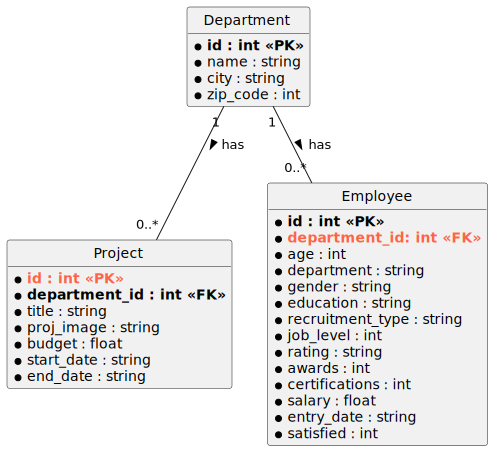

In [9]:
%%plantuml 

@startuml

hide circle
hide members
show fields

class "Department" as d {
    * **id : int <<PK>>**
    * name : string
    * city : string
    * zip_code : int
}

class "Project" as p {
    * <color:Tomato>**id : int <<PK>>**</color>
    * **department_id : int <<FK>>**
    * title : string
    * proj_image : string
    * budget : float
    * start_date : string
    * end_date : string
}

class "Employee" as e {
    * **id : int <<PK>>**
    * <color:Tomato>**department_id: int <<FK>>**</color>
    * age : int
    * department : string
    * gender : string
    * education : string
    * recruitment_type : string
    * job_level : int
    * rating : string
    * awards : int
    * certifications : int
    * salary : float
    * entry_date : string
    * satisfied : int
}


d "1" -- "0..*" e : has >
d "1" -- "0..*" p : has >
   
@enduml

> *HINWEIS:* Attribute wie *Employee.entry_date* wurden hier als *string* dargestellt, da eine automatische Erfassung von Datentypen mit Tools wie *xsv* Strings, die ein Datum enthalten diesen nicht immer als *date* erkennen! Außerdem können Spalten Werte in verschiedenen Datentypen enthalten (in diesem Fall enhält die Spalte *Employee.rating* String- und Float-Werte). Diese werden von Tools wie *xsv* dann ebenfalls als String erkannt. Für den Import in ein Datenbanksystem müssen diese gegebenenfalls angepasst werden!

## PostgreSQL    

Im Folgenden sollen die vorhandenen Daten zunächst in ein relationales Datenbanksystem - in diesem Fall PostgreSQL - importiert werden.

<div class="alert alert-block alert-info">
    
**Aufgabe 2**    
    
Bilden Sie das in Aufgabe 1 aus den vorhandenen Daten extrahiert Modell jetzt geeignet auf das relationale Datenmodell ab (pysisches Modell). Hierbei muss im Sinne einer Normalisierung kein weitere Aufteilung der Tabellen vorgenommen werden.    Markieren Sie ebenfalls wieder farblich für die Modellierung notwendigen Attribute, die in den vorhandenen Daten fehlen. Kennzeichnen Sie ebenfalls redundante Attribute die Sie an dieser Stelle entfernen würden. 
</div>



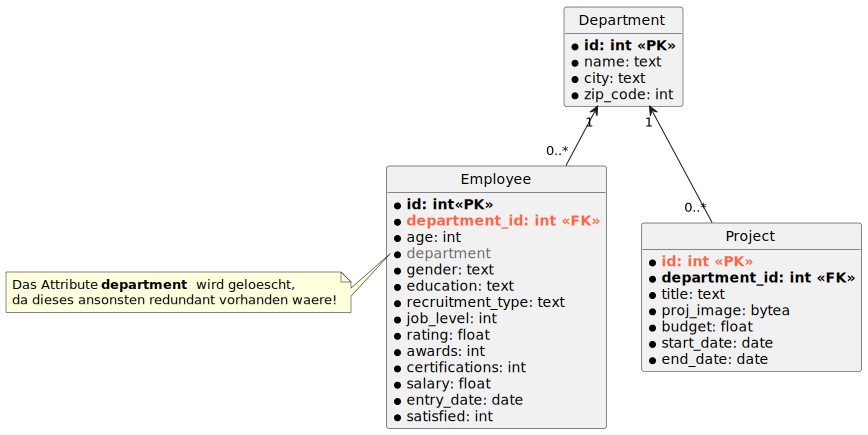

In [10]:
%%plantuml
@startuml

hide circle
hide members
show fields

class "Department" as d {
    * **id: int <<PK>>**
    * name: text
    * city: text
    * zip_code: int
}

class "Project" as p {
    * <color:Tomato>**id: int <<PK>>**</color>
    * **department_id: int <<FK>>**
    * title: text
    * proj_image: bytea
    * budget: float
    * start_date: date
    * end_date: date 
}

class "Employee" as e {
    * **id: int<<PK>>**
    * <color:Tomato>**department_id: int <<FK>>**</color>
    * age: int
    * <color:DimGrey>department</color>
    * gender: text
    * education: text
    * recruitment_type: text
    * job_level: int
    * rating: float
    * awards: int
    * certifications: int
    * salary: float
    * entry_date: date
    * satisfied: int
}

note left of e::<color:DimGrey>department</color>
    Das Attribute **department** wird geloescht, 
    da dieses ansonsten redundant vorhanden waere!
end note


d "1" <-- "0..*" e
d "1" <-- "0..*" p
   
@enduml

### Data Preparation   

$$ \\ $$

<div class="alert alert-block alert-info">

**Aufgabe 3**
    
Nehmen Sie an dieser Stelle für den Import möglicherweise notwendige Änderungen an den Daten vor. Es steht Ihnen frei dies mithilfe von Bash-Tools, Python-Skripten oder sonstigen Werkzeugen umzusetzen. 

Beschreiben Sie außerdem nachvollziehbar - mit Kommentaren im Code oder Markdown-Zellen - welche Änderungen Sie vornehmen und wieso Sie diese vornehmen.
</div>



1. Der Header wird aus den CSV-Dateien entfernt. Dies erleichtern den späteren Import in MongoDB mithilfe von *mongoimport*. Die Header werden zusätzlich in einer Textdatei abgelegt.

In [ ]:
%%bash

## move csv header to extra file
head -1 ${DATA_PATH}/employees_satisfaction_transformed.csv > \
${DATA_PATH}/employees_satisfaction_transformed-header.txt

head -1 ${DATA_PATH}/projects.csv > \
${DATA_PATH}/projects-header.txt

head -1 ${DATA_PATH}/departments.csv > \
${DATA_PATH}/departments-header.txt

## and remove the header from file
tail -n +2 ${DATA_PATH}/departments.csv > ${DATA_PATH}/tmp.csv && \
mv ${DATA_PATH}/tmp.csv ${DATA_PATH}/departments.csv

tail -n +2 ${DATA_PATH}/projects.csv > ${DATA_PATH}/tmp.csv \
&& mv ${DATA_PATH}/tmp.csv ${DATA_PATH}/projects.csv

tail -n +2 ${DATA_PATH}/employees_satisfaction_transformed.csv > ${DATA_PATH}/tmp.csv && \
mv ${DATA_PATH}/tmp.csv ${DATA_PATH}/employees_satisfaction_transformed.csv

2. Beim Import nach PostgreSQL kommt es zu einem Fehler, da die Spalte *rating* in der Datei *employees_satisfaction_transformed.csv* strings und numerische Werte enthält. Folgendermaßen kann dies überprüft und korrigiert werden

In [ ]:
%%bash

## delete the string values 
sed -i 's/,Unavailable,/,,/g' ${DATA_PATH}/employees_satisfaction_transformed.csv

In [ ]:
%%bash

printf "\n## test for datatype\n"
if [ -z $(cat ${DATA_PATH}/employees_satisfaction_transformed.csv |
awk -F"," '{print $7}' | sort | uniq | grep -v '[0-9]*\.[0-9]*') ]; then
    printf "  only numeric values found in column 7 (rating) :)\n";
else
    printf "  not only numeric values found :(\n";
fi

# show the unique content of the row
printf "\n## unique values\n"
cat ${DATA_PATH}/employees_satisfaction_transformed.csv |
awk -F"," '{print $7}' | sort | uniq -c

### Datenimport     


Starten Sie jetzt einen Docker-Container mit einer PostgreSQL-Datenbank, innerhalb des Docker-Netzwerks, in dem sich alle weiteren hier verwendeten Container befinden.

In [ ]:
%%bash

sudo docker run -d --rm \
--name dbis-postgres-db-1 \
--hostname dbis-postgres-db-1 \
-v "${HOST_DATA_PATH}:/mnt/workspace:ro" \
-e POSTGRES_PASSWORD=root \
-p 127.0.0.1:5432:5432 \
--network dbis-hadoop-cluster-network \
postgres:14.4

Vergewissern Sie sich, dass der Container läuft:

In [ ]:
%%bash
sudo docker ps --filter "name=dbis-postgres-db-1" --format "table {{.Names}}\t{{.Status}}"

<div class="alert alert-block alert-info">
    
**Aufgabe 4**    
    
Schreiben Sie ein SQL-Skript, das die notwendigen Schema-Strukturen anlegt, die CSV-Dateien einliest und entsprechend dem in Aufgabe 2 entworfenem Modell "Umstrukturierungen" vornimmt. Vervollständigen Sie hierzu das nachfolgende SQL-Skript.

Sie können natürlich auch abweichend alternative Methoden bzw. Tools verwenden. Der Python-Treiber für PostgreSQL ([psycopg](https://www.psycopg.org/psycopg3/docs/)) ist bereits installiert.
</div>


> *HINWEIS:* Der Import der Daten kann mehrere Minuten in Anspruch nehmen! Bezüglich der benötigten SQL-Aufrufe kann die Online-Dokumentation von PostgreSQL hilfreich sein (beispielsweise hinsichtlich des *COPY-FROM*-Befehls: [https://www.postgresql.org/docs/14/sql-copy.html](https://www.postgresql.org/docs/14/sql-copy.html)).


In [ ]:
%%bash

cat <<"EOF" | sudo docker exec -i dbis-postgres-db-1 psql -U postgres

DROP DATABASE IF EXISTS satisfaction;
CREATE DATABASE satisfaction;
\c satisfaction;

/*==============================================================*/
/* Table: Department                                            */
/*==============================================================*/
\qecho ** CREATE TABLE Department ...
CREATE TABLE Department (
   id                   int               not null,
   name                 text              not null,        
   city                 text              not null,
   zip_code             int               not null,
   CONSTRAINT pk_department PRIMARY KEY (id)
);

\qecho ** COPY from CSV-file into Department ...
COPY 
    Department(id,name,city,zip_code)
FROM 
   '/mnt/workspace/departments.csv'
WITH (
    FORMAT CSV,
    DELIMITER ',',
    HEADER false,
    NULL ''
);

/*==============================================================*/
/* Table: Project                                               */
/*==============================================================*/

\qecho ** CREATE a temporary TABLE Project_tmp ...
CREATE TABLE Project_tmp (
   id                   serial               PRIMARY KEY,
   department_id        int                  not null,
   title                text                 not null,
   proj_image           text                 null,
   budget               float                not null,
   start_date           date                 not null,
   end_date             date                 not null 
);

\qecho ** COPY from CSV-file into temporary Table Project_tmp ...
COPY 
    Project_tmp(department_id,title,proj_image,budget,start_date,end_date)
FROM 
    '/mnt/workspace/projects.csv'
WITH (
    FORMAT CSV,
    DELIMITER ',',
    HEADER false,
    NULL ''
);

\qecho ** CREATE TABLE Project ...
CREATE TABLE Project (
   id                   int                  not null,
   department_id        int                  not null,
   title                text                 not null,
   proj_image           bytea                null,
   budget               float                not null,
   start_date           date                 not null,
   end_date             date                 not null,
   CONSTRAINT pk_project PRIMARY KEY (id)
);

\qecho ** COPY from temporary table Project_tmp to Project (DECODE base_64 image) ...
INSERT INTO Project(id,department_id,title,proj_image,budget,start_date,end_date)
SELECT
   id,
   department_id,
   title,
   DECODE(proj_image, 'base64'),
   budget,
   start_date,
   end_date
FROM Project_tmp;

\qecho ** DROP TABLE Project_tmp ...
DROP TABLE Project_tmp;


/*==============================================================*/
/* Table: Employee                                              */
/*==============================================================*/
\qecho ** CREATE TABLE Employee ...
CREATE TABLE Employee (
   id                   int                  not null,
   department           text                 not null,
   department_id        int                  null,
   satisfied            int                  not null,
   age                  int                  not null,
   gender               text                 not null,
   education            text                 not null,
   recruitment_type     text                 not null,
   job_level            int                  not null,
   rating               float                null,
   awards               int                  not null,
   certifications       int                  not null,
   salary               float                not null,
   entry_date           date                 not null,
   CONSTRAINT pk_employee PRIMARY KEY (ID)
);

\qecho ** COPY vom CSV-file into Employee ...
COPY 
    Employee(id,age,department,education,recruitment_type,job_level,rating,awards,certifications,
             salary,gender,entry_date,satisfied)
FROM 
    '/mnt/workspace/employees_satisfaction_transformed.csv'
WITH (
    FORMAT CSV,
    DELIMITER ',',
    HEADER false,
    NULL ''
);

/*==============================================================*/
/* Add Foreign Key constraint to Project table                  */
/*==============================================================*/

\qecho ** ALTER TABLE Project (set 'department_id' as foreign key) ...
ALTER TABLE Project
    ADD CONSTRAINT fk_project_department FOREIGN KEY (department_id)
        REFERENCES Department (id)
    ON DELETE RESTRICT 
    ON UPDATE RESTRICT;


/*==============================================================*/
/* Insert Foreign Key values to Employee table                  */
/*==============================================================*/

-- Insert values to Employee.department_id
\qecho ** UPDATE Employee (add values to column 'department_id') ...
UPDATE Employee
   SET department_id = d.id
   FROM (
      SELECT id, name
      FROM Department
      ) AS d
   WHERE d.name = Employee.department;

-- Set Employee.department_id to not null
\qecho ** ALTER TABLE Employee (set 'department_id' to NOT NULL) ...
ALTER TABLE Employee 
    ALTER COLUMN department_id SET NOT NULL;


/*==============================================================*/
/* Add Foreign Key constraint to Employee table                 */
/*==============================================================*/

\qecho ** ALTER TABLE Employee (set 'department_id' as foreign key) ...
ALTER TABLE Employee
    ADD CONSTRAINT fk_employee_department FOREIGN KEY (department_id)
        REFERENCES Department (id)
    ON DELETE RESTRICT 
    ON UPDATE RESTRICT;


/*==============================================================*/
/* Remove attribute department from Employee table              */
/*==============================================================*/

\qecho ** ALTER TABLE Employee (remove column 'department') ...
ALTER TABLE Employee
    DROP COLUMN department;

EOF

Verwendung des Python Driver:

In [ ]:
import psycopg

postgres_conn = None
postgres_cursor = None
try:
    postgres_conn = psycopg.connect("host='dbis-postgres-db-1' dbname='satisfaction' user='postgres' password='root'")
    postgres_cursor = postgres_conn.cursor()
except psycopg.DatabaseError:
    print("No database connection!")

*Optional:* Anzeigen eines Project-Image (Bild):

In [ ]:
import base64
from IPython.display import Image

postgres_cursor.execute("SELECT proj_image FROM Project WHERE id = 42")
postgres_conn.commit()

result = postgres_cursor.fetchone()

Image(result[0])

### Datenbankabfragen    

$$ \\ $$

<div class="alert alert-block alert-info">
    
**Aufgabe 5**    
    
Schreiben Sie nun für nachfolgende Abfragen SQL-Statements und führen diese aus. Sie können entweder das vorgegebene SQL-Skript oder den Python-Treiber verwenden. Zu jeder Abfrage werden außerdem die Attribute angegeben, die jeweils ausgegeben werden sollen.
</div>

- **Q1. Anzahl Projekte pro Department**
    - Auszugebende Attribute: *Department.id, Department.name, Department.city, Department.zip_code, count_projects*
    - Erwartetes Ergebnis:


 id  |    name    |      city      | zip_code | count_projects 
-----|------------|----------------|----------|----------------
 101 | HR         | Frankfurt a.M. |    60306 |             85
 103 | Purchasing | München        |    80331 |            102
 104 | Sales      | Hamburg        |    21140 |             59
 105 | Technology | Berlin         |    10115 |            406
 102 | Marketing  | Berlin         |    10115 |            348
  

- **Q2. Durchschnittliche Dauer aller Projekte**
    - Auszugebende Attribute: *avg_project_duration_days*
    - Erwartetes Ergebnis:
    
|  avg_proj_duration_days |
|-------------------------|
|   932.6690000000000000  |
  
- **Q3. Durchschnittliche Projektdauer pro Department**
    - Auszugebende Attribute: *Department.id, Department.name, Department.city, Department.zip_code, avg_project_duration_days*
    - Erwartetes Ergebnis:   
  

 id  |    name    |      city      | zip_code | avg_proj_duration_days 
-----|------------|----------------|----------|------------------------
 101 | HR         | Frankfurt a.M. |    60306 |   992.2000000000000000
 103 | Purchasing | München        |    80331 |   993.4509803921568627
 104 | Sales      | Hamburg        |    21140 |   856.1864406779661017
 105 | Technology | Berlin         |    10115 |   946.0270935960591133
 102 | Marketing  | Berlin         |    10115 |   897.6954022988505747
 

- **Q4. Durchschnittliche Satisfaction pro Department**
    - Auszugebende Attribute: *Department.id, Department.name, Department.city, Department.zip_code, avg_satisfied*
    - Erwartetes Ergebnis:   


 id  |    name    |      city      | zip_code |     avg_satisfied      
-----|------------|----------------|----------|------------------------
 101 | HR         | Frankfurt a.M. |    60306 | 0.68867924528301886792
 103 | Purchasing | München        |    80331 | 0.70175438596491228070
 104 | Sales      | Hamburg        |    21140 | 0.80459770114942528736
 105 | Technology | Berlin         |    10115 | 0.74489795918367346939
 102 | Marketing  | Berlin         |    10115 | 0.64516129032258064516
    

- **Q5. Durchschnittliche Projektdauer des "Technology" Departments**
    - Auszugebende Attribute: *Department.id, Department.name, Department.city, Department.zip_code, avg_proj_duration_days*
    - Erwartetes Ergebnis:


 id  |    name    |  city  | zip_code | avg_proj_duration_days 
-----|------------|--------|----------|------------------------
 105 | Technology | Berlin |    10115 |   946.0270935960591133    


- **Q6. Satisfaction des "Technology" Departments**
    - Auszugebende Attribute: *Department.id, Department.name, Department.city, Department.zip_code, avg_satisfied*
    - Erwartetes Ergebnis:


 id  |    name    |  city  | zip_code |     avg_satisfied      
-----|------------|--------|----------|------------------------
 105 | Technology | Berlin |    10115 | 0.74489795918367346939



In [ ]:
%%bash
cat <<"EOF" | sudo docker exec -i dbis-postgres-db-1 psql -U postgres -d satisfaction

\qecho ******** Q1 ********
SELECT
    d.id,
    d.name,
    d.city,
    d.zip_code,
    COUNT(d.name) AS count_projects
    FROM Department d
    JOIN Project p
    ON d.id = p.department_id
    GROUP BY d.name, d.id;

\qecho ******** Q2 ********
SELECT 
   AVG(end_date - start_date) AS avg_proj_duration_days 
FROM Project;

\qecho ******** Q3 ********
SELECT 
    d.id, 
    d.name, 
    d.city, 
    d.zip_code, 
    AVG(p.end_date - p.start_date) AS avg_proj_duration_days 
FROM 
    Department d
JOIN 
    Project p
ON d.id = p.department_id
GROUP BY d.name, d.id;

\qecho ******** Q4 ********
SELECT 
    d.id, 
    d.name, 
    d.city, 
    d.zip_code, 
    AVG(satisfied) AS avg_satisfied 
FROM 
    Department d
JOIN 
    Employee e
ON d.id = e.department_id
GROUP BY d.name, d.id;

\qecho ******** Q5 ********
SELECT 
    d.id, 
    d.name, 
    d.city, 
    d.zip_code, 
    AVG(p.end_date - p.start_date) AS avg_proj_duration_days 
FROM 
    Department d
JOIN 
    Project p
ON d.id = p.department_id
WHERE
    d.name = 'Technology'
GROUP BY d.name, d.id;

\qecho ******** Q6 ********
SELECT 
    d.id, 
    d.name, 
    d.city, 
    d.zip_code, 
    AVG(satisfied) AS avg_satisfied 
FROM 
    Department d
JOIN 
    Employee e
ON d.id = e.department_id
WHERE
    d.name = 'Technology'
GROUP BY d.name, d.id;

EOF

**Alternativ kann auch der Python-Treiber (psycopg) verwendet werden:**

In [ ]:
from pprint import pprint
q1 = """ 
SELECT
    d.id,
    d.name,
    d.city,
    d.zip_code,
    COUNT(d.name) AS count_projects
FROM Department d
JOIN Project p
    ON d.id = p.department_id
GROUP BY d.name, d.id
"""

postgres_cursor.execute(q1)
postgres_conn.commit()

result = postgres_cursor.fetchall()
pprint(result)

Die Datenbankverbindung wieder schließen:

In [ ]:
if postgres_conn:
    postgres_conn.close()

Abschließend kann der Datenbank-Container folgendermaßen wieder gestoppt werden (zu beachten gilt, dass aufgrund des `--rm` Flags der Container nach dem Stoppen automatisch gelöscht wird): 

In [ ]:
%%bash

# stop the postgresql docker container
if [ -z $(sudo docker ps --filter "name=dbis-postgres-db-1" -q) ]; then
    printf "\nthe container does not exist\n";
else 
    printf "\nstopping the container ...\n";
    sudo docker stop dbis-postgres-db-1
fi

## MongoDB    

Nachdem die zur Verfügung stehenden Daten in ein relationales Datenbanksystem importiert wurden, beschäftigen wir uns im Folgenden mit der Modellierung und Import bezüglich des dokument-orientierten Datenbanksystems MongoDB.

<div class="alert alert-block alert-info">
    
**Aufgabe 6**    
    
Bilden Sie das in Aufgabe 1 aus den vorhandenen Daten extrahiert Modell jetzt geeignet auf das Modell von MongoDB ab (inklusive Datentypen). Optimieren bzw. gestalten Sie das Modell so, dass für die geplanten Abfragen keine Joins benötigt werden ([*\$lookup*](https://www.mongodb.com/docs/manual/reference/operator/aggregation/lookup/))! Begründen Sie ihre Entscheidungen bezüglich des Schema-Designs (Einbettung, Referenzierung, Redundanz), wo dieses vom Modell aus Aufgabe 1 abweicht.
</div>


> *HINWEIS:* Integer Type Limits in MongoDB:

- int32: -2.147.483.648 to 2.147.483.647
- int64: -9.223.372.036.854.775.808 to 9.223.372.036.854.775.807


In [ ]:
%%plantuml --jar

@startuml

hide circle
hide members
show fields

class "**Department**" as d {
    _id: int64 <<PK>>
    name: string
    city: string
    zip_code: int32
    employees: array[object]
}

class "**Project**" as p {
    <color:Tomato>**_id: objectid <<PK>>**</color>
    department_id: int64 <<FK>>
    title: string
    proj_image: binary
    budget: double
    start_date: date
    end_date: date
    <color:blue>department_name: string</color>
    <color:blue>department_city: string</color>
    <color:blue>department_zip_code: int32</color>
}

class "**Employee**" as e #lightblue {
    _id: int64
    age: int
    gender: string
    education: string
    recruitment_type: string
    job_level: int
    rating: double
    awards: int
    certifications: int
    salary: double
    entry_date: date
    satisfied: int
}


d "1" *--> "0..*" e
d "1" <-- "0..*" p
   
@enduml

**Begründung:**

- Zur Vermeidung von Joins bei Abfrage 4 und 6 werden die Employee-Dokumente in Department eingebettet.
- Department und Project werden ebenfalls gemeinsam abgefragt. Hier ist es allerdings aufgrund der Dokumentgröße von "Project" nicht möglich diese in "Department" einzubetten. Daher werden zur Vermeidung von Joins die für die Abfragen benötigten Attribute aus "Department" redundant in "Project" gespeichert.

> *HINWEIS*: Hier ist es nicht notwendig den Datentyp "int64" für Schlüsselattribute zu verwenden ("int32" ist auch vollkommen ausreichend)! Außerdem wurde hier der in "Project" fehlende Primärschlüssel automatisch von MongoDB während des Datenimports generiert, wodurch dieser abweichend vom Typ "objectid" ist! Besser wäre natürlich, wenn die Datentypen der Schlüsselattribute konsistent sind :)

### Datenimport    

Starten Sie jetzt eine MongoDB Datenbank innerhalb des Docker-Netzwerks in dem sich alle weiteren hier verwendeten Container befinden.

In [ ]:
%%bash

sudo docker run -d --rm \
--name dbis-mongo-db-1 \
--hostname dbis-mongo-db-1 \
-v "${HOST_DATA_PATH}:/mnt/workspace:ro" \
-e BROWSERSLIST_IGNORE_OLD_DATA=1 \
--network dbis-hadoop-cluster-network \
-p 127.0.0.1:27017:27017 \
mongo:5.0.5-focal

Vergewissern Sie sich wieder, dass der Container läuft:

In [ ]:
%%bash
sudo docker ps --filter "name=dbis-mongo-db-1" --format "table {{.Names}}\t{{.Status}}"

<div class="alert alert-block alert-info">
    
**Aufgabe 7**    
    
Importieren Sie die Daten nach MongoDB (schauen Sie sich diesbezüglich die Dokumentation zu [mongoimport](https://www.mongodb.com/docs/database-tools/mongoimport/) an). Achten Sie insbesondere auf die entsprechenden Datentypen.
    
Nehmen Sie außerdem bezüglich dem in Aufgabe 6 erstellten Modell notwendige "Umstrukturierungen" der Daten vor. Hierbei sind unterschiedliche Vorgehensweisen denkbar. Es können Beispielsweise die Daten zunächst so wie sie vorliegen in MongoDB importiert und anschließend durch entsprechende Aufrufe (*\$lookup*, *\$addFields*, *\$merge*, ...) umstrukturiert werden. Die Daten können natürlich auch vorher - beispielsweise mit Python - in die benötigte Struktur überführt und anschließend importiert werden.

Abweichend zu *mongoimport* kann hier auch der [*pymongo*](https://pymongo.readthedocs.io/en/stable/) Python-Treiber verwendet werden. Dieser ist ebenfalls bereits installiert.
</div>

Die Daten werde hier zunächst so wie sie vorliegen importiert.

In [ ]:
%%bash

## Insert Departments
printf "\n## Import to Department ...\n"
sudo docker exec -i dbis-mongo-db-1 mongoimport \
--drop \
--db=satisfaction \
--collection=Department \
--numInsertionWorkers=4 \
--type=csv \
--columnsHaveTypes \
--fields="_id.int64(),name.string(),city.string(),zip_code.int32()" \
--file=/mnt/workspace/departments.csv

In [ ]:
%%bash
## Insert Projects
sudo docker exec -i dbis-mongo-db-1 mongoimport \
--drop \
--db=satisfaction \
--collection=Project \
--numInsertionWorkers=4 \
--type=csv \
--columnsHaveTypes \
--fields="department_id.int64(),title.string(),proj_image.binary(base64),budget.double(),start_date.date(2006-01-02 15:04:05),end_date.date(2006-01-02 15:04:05)" \
--file=/mnt/workspace/projects.csv

In [ ]:
%%bash
## Insert Employees
sudo docker exec -i dbis-mongo-db-1 mongoimport \
--drop \
--db=satisfaction \
--collection=Employee \
--numInsertionWorkers=4 \
--type=csv \
--columnsHaveTypes \
--ignoreBlanks \
--fields="_id.int64(),age.int32(),department.string(),education.string(),recruitment_type.string(),job_level.int32(),rating.double(),awards.int32(),certifications.int32(),salary.double(),gender.string(),entry_date.date(2006-01-02),satisfied.int32()" \
--file=/mnt/workspace/employees_satisfaction_transformed.csv

**Schema-Modifikationen**    

1. Die Attribute *name*, *city* und *zip_code* aus "Department" werden redundant zu den entpsrechenden Projekten hinzugefügt:

In [ ]:
%%bash

# add attributes from department to project
sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'db.Project.aggregate([
        {
            $lookup: {
                from: "Department",
                localField: "department_id",
                foreignField: "_id",
                as: "department_obj"
            }
        },
        {
            $addFields: {
                department_name : { $first: "$department_obj.name" },
                department_city : { $first: "$department_obj.city" },
                department_zip_code : { $first: "$department_obj.zip_code" }
            }
        },
        {
            $project: {
                department_obj : 0
            }
        },
        {
            $merge: {
                into: "Project",
                whenMatched: "replace",
                whenNotMatched: "discard"
            }
        }
])'

2. Employee-Dokumente werden in die entsprechenden Department-Dokumente eingebettet. Außerdem kann daraufhin die Employee-Collection gelöscht werden, da jeder Mitarbeiter einem Department zugeteilt ist!

In [ ]:
%%bash

## embed employees in departments
sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'db.Department.aggregate([
        {
            $lookup: {
                from: "Employee",
                localField: "name",
                foreignField: "department",
                as: "employees"
            }
        },
        {
            $project: {
                "employees.department" : 0,
                "employees.department_id" : 0
            }
        },
        {
            $merge: {
                into: "Department",
                whenMatched: "replace",
                whenNotMatched: "discard"
            }
        }
]);
// delete the Employee Collection
db.Employee.drop();'

### Datenbankabfragen    

<div class="alert alert-block alert-info">
    
**Aufgabe 8**    
    
Führen Sie nun wieder die vorgegeben Abfragen aus (siehe Aufgabe 5). Nochmals der Hinweis, dass keine Joins (*\$lookup*) verwendet werden sollen. Außerdem sollten *\$unwind*-Operationen möglichst vermieden werden.

Alternativ zu dem vorgegebenen Rahmen (Verwendung der Mongo-Shell) können Sie ebenfalls den *pymongo* Python-Treiber verwenden.
</div>

*Q1*. Anzahl Projekte pro Department 

In [ ]:
%%bash

sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'print("******** Q1 ******** ");
db.Project.aggregate([   
        {
            $group: {
                _id: "$department_name",
                count_projects: {
                    $count: { }
                },
                city: { $first: "$department_city" },
                zip_code: { $first: "$department_zip_code" }
            }
        }
]);'

**Alternativ kann auch der Python-Driver verwendet werden:**

In [ ]:
from pymongo import MongoClient
from pprint import pprint

mongo_client = MongoClient('mongodb://dbis-mongo-db-1:27017/')
mongo_db = mongo_client['satisfaction']

pipeline = [{
    "$group" : {
        "_id": "$department_name",
        "count_projects": {
            "$count": { }
        },
        "city": { "$first": "$department_city" },
        "zip_code": { "$first": "$department_zip_code" }
    }
}]
    
result = mongo_db['Project'].aggregate(pipeline)
pprint(list(result))
       
mongo_client.close()

*Q2*. Durchschnittliche Projektdauer aller Projekte 

In [ ]:
%%bash

sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'print("******** Q2 ******** ");
db.Project.aggregate([{
            $group: {
                _id: null,
                averageTime: {
                    $avg: {
                        $dateDiff: {
                            startDate: "$start_date",
                            endDate: "$end_date",
                            unit: "day"
                        }
                    }
                }
            }
        },
        {
            $project: {
                _id: 0,
                avg_proj_duration_days: {
                    // truncates a number to a whole integer or to a specified decimal place
                    $trunc: ["$averageTime", 2]
                }
            }
        }
])'

*Q3*. Durchschnittliche Projektdauer pro Department 

In [ ]:
%%bash

sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'print("******** Q3 ******** ");
db.Project.aggregate([   
        {
            $group: {
                _id: "$department_name",
                avg_proj_duration_days: {
                    $avg: {
                        $dateDiff: {
                            startDate: "$start_date",
                            endDate: "$end_date",
                            unit: "day"
                        }
                    }
                },
                city: { $first: "$department_city" },
                zip_code: { $first: "$department_zip_code" }
            }
        }
])'

*Q4*. Durchschnittliche Sat. pro Department

In [ ]:
%%bash

sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'print("******** Q4 ******** ");
db.Department.find({},{
    _id : 0,
    name : 1,
    city: 1,
    zip_code: 1,
    avg_proj_satisfied: { $avg: "$employees.satisfied" }
})'

*Q5.* Durchschnittliche Projektdauer des "Technology" Departments 

In [ ]:
%%bash

sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'print("******** Q5 ******** ");
db.Project.aggregate([   
        {
            $match: {
                department_name: "Technology"
            }
        },
        {
            $group: {
                _id: "$department_name",
                avg_proj_duration_days: {
                    $avg: {
                        $dateDiff: {
                            startDate: "$start_date",
                            endDate: "$end_date",
                            unit: "day"
                        }
                    }
                },
                city: { $first: "$department_city" },
                zip_code: { $first: "$department_zip_code" }
            }
        }
])'

*Q6.* Satisfaction des "Technology" Departments

In [ ]:
%%bash

sudo docker exec -i dbis-mongo-db-1 mongosh satisfaction --quiet --eval \
'print("******** Q6 ******** ");
db.Department.find({
    name: "Technology"
},{
    _id : 0,
    name : 1,
    city: 1,
    zip_code: 1,
    avg_proj_satisfied: { $avg: "$employees.satisfied" }
})'

Der MongoDB-Container kann folgendermaßen wieder gestoppt werden:

In [ ]:
%%bash

# stop the mongodb docker container
if [ -z $(sudo docker ps --filter "name=dbis-mongo-db-1" -q) ]; then
    printf "\nthe container does not exist\n";
else 
    printf "\nstopping the container ...\n";
    sudo docker stop dbis-mongo-db-1
fi

## Cassandra

Abschließend, beschäftigen wir uns mit der Modellierung und Import bezüglich des spalten-orientierten Datenbanksystems Cassandra.

Machen sie sich hierzu zunächst mit der Daten-Modellierung in Cassandra vertraut (siehe: [https://cassandra.apache.org/doc/latest/cassandra/data_modeling/index.html](https://cassandra.apache.org/doc/latest/cassandra/data_modeling/index.html))

### Datenmodellierung    

<div class="alert alert-block alert-info">
    
**Aufgabe 9**    
    
Erstellen Sie ein *Chebotko logical data model* bezüglich der Datenbankabfragen *Q1, Q2, Q5, Q6* (siehe [https://cassandra.apache.org/doc/latest/cassandra/data_modeling/data_modeling_logical.html](https://cassandra.apache.org/doc/latest/cassandra/data_modeling/data_modeling_logical.html)). Beachten Sie dabei, dass wir jetzt - im Gegensatz zu der Modellierung und Import bei PostgreSQL und MongoDB - nur die in den Abfragen benötigten Attribute modellieren und importieren. Beachten Sie außerdem, dass wir im Gegensatzt zu dem in der Cassandra-Dokumentation verwendeten "Hotel-Beispiel" keinen Workflow zwischen den Abfragen haben und somit die "Tabellen" in unserem Diagramm auch nicht in Bezug zueinander stehen werden.
</div>



- **Q1.** Anzahl Projekte pro Department 
- **Q2.** Durchschnittliche Dauer aller Projekte 
- **Q5.** Durchschnittliche Projektdauer des "Technology" Departments 
- **Q6.** Durchschnittliche Employee satisfaction des "Technology" Departments 

In [ ]:
%%plantuml --jar

@startuml

hide members
hide circle
show fields

class **project_count_by_department**<Q1> {
department_name  **K**
project_id  **C↑**
department_city  **S**
department_zip_code  **S**
}


class **avg_project_duration**<Q2> {
project_id  **K**
project_start_date  **C↑**
project_end_date
}


class **avg_project_duration_by_department**<Q5> {
department_name  **K**
project_id  **C↑**
department_city  **S**
department_zip_code  **S**
project_start_date
project_end_date
}


class **avg_employee_satisfaction_by_department**<Q6> {
department_name  **K**
employee_id  **C↑**
department_city  **S**
department_zip_code  **S**
employee_satisfied
}

@enduml

<div class="alert alert-block alert-info">
    
**Aufgabe 10**    
    
Erstellen Sie jetzt ein *Chebotko physical data model*. Fassen Sie dabei, wenn möglich, Tabellen aus der logischen Modellierung (eine Tabelle je Abfrage) zusammen.
</div>

In [ ]:
%%plantuml --jar

@startuml

hide members
hide circle
show fields
   
package Satisfaction_Keyspace <<Rectangle>> {
    class **projects_by_department**<Q1, Q2, Q5> {
        department_name : text **K**
        project_id : int  **C↑**
        department_city : string  **S**
        department_zip_code : int  **S**
        project_start_date : timestamp
        project_end_date : timestamp
    }


    class **employees_by_department**<Q6> {
        department_name : text  **K**
        employee_id : int **C↑**
        department_city : text  **S**
        department_zip_code : int  **S**
        employee_satisfied : int
    }
}

@enduml

### Datenimport

Starten Sie eine Cassandra Datenbank. Das hier verwendete Docker-Image beinhaltete bereits den DataStax Bulk Reader für einen effizienten Import von CSV-Dateien ([https://docs.datastax.com/en/dsbulk/docs/dsbulkAbout.html](https://docs.datastax.com/en/dsbulk/docs/dsbulkAbout.html)).

In [ ]:
%%bash

sudo docker run -d --rm \
--name dbis-cassandra-db-1 \
--hostname dbis-cassandra-db-1 \
-v "${HOST_DATA_PATH}:/mnt/workspace:ro" \
--network dbis-hadoop-cluster-network \
-p 127.0.0.1:7000:7000 \
registry.dbis-pro1.fernuni-hagen.de/pub-access/data-engineering-infrastructure/cassandra:4.0.4-dsbulk-1.10

Vergewissern Sie sich, dass der Docker-Container läuft:

In [ ]:
%%bash
sudo docker ps --filter "name=dbis-cassandra-db-1" --format "table {{.Names}}\t{{.Status}}"

<div class="alert alert-block alert-info">
    
**Aufgabe 11**    
    
Vervollständigen Sie jetzt das nachfolgende CQL-Skript für die Erzeugung des Schemas.
</div>


> *HINWEIS:* Es kann mehrere Minuten dauern, bis die Datenbank vollständig gestartet ist!


In [ ]:
%%bash

cat <<"EOF" | sudo docker exec -i dbis-cassandra-db-1 cqlsh

DROP KEYSPACE IF EXISTS satisfaction;
CREATE KEYSPACE satisfaction
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor' : 1};

USE satisfaction;

DROP TABLE IF EXISTS projects_by_department;
CREATE TABLE projects_by_department ( 
    department_name text,
    project_id int,
    department_city text static,
    department_zip_code int static,
    project_start_date timestamp,
    project_end_date timestamp,
    PRIMARY KEY ((department_name), project_id)
) WITH comment = 'Q1, Q2, Q5. Count projects per department. Get average project duration of all projects. Get average project duration per department'
AND CLUSTERING ORDER BY (project_id ASC);


DROP TABLE IF EXISTS employees_by_department;
CREATE TABLE employees_by_department ( 
    department_name text,
    employee_id int,
    department_city text static,
    department_zip_code int static,
    employee_satisfied int,
    PRIMARY KEY ((department_name), employee_id)
) WITH comment = 'Q6. Get average saturation per department'
AND CLUSTERING ORDER BY (employee_id ASC);

DESCRIBE KEYSPACE satisfaction;

EOF

<div class="alert alert-block alert-info">
    
**Aufgabe 12**    
    
Erzeugen Sie zunächst die für den Import in Cassandra benötigten CSV-Dateien. Hier sind wieder unterschiedliche Vorgehensweisen denkbar. Beispielsweise haben wir die Daten bereits in PostgreSQL importiert und könnten diese durch den COPY-TO-Befehl in der benötigten Form exportierten. Es steht Ihnen an dieser Stelle ebenfalls wieder Frei auf welche Weise die Daten in die benötigte Struktur überführt und importiert werden. Der Python-Treiber für Cassandra ([*cassandra-driver*](https://docs.datastax.com/en/developer/python-driver/3.25/)) ist ebenfalls bereits installiert.
</div>


Da die Daten bereits in PostgreSQL importiert wurden können wir mithilfe der entsprechender Abfragen die Daten mit wenig Aufwand in der benötigten Struktur aus PosgreSQL exportieren:

In [ ]:
%%bash

cat <<"EOF" | sudo docker exec -i dbis-postgres-db-1 psql -U postgres -d satisfaction

\qecho ## Export department_projects
COPY (
    SELECT
        TRIM(d.name) AS department_name,
        p.id AS project_id,
        TRIM(d.city) AS department_city,
        d.zip_code AS department_zip_code,
        p.start_date AS project_start_date,
        p.end_date AS project_end_date
    FROM
        Department d
    JOIN
        Project p
    ON d.id = p.department_id
    ORDER BY d.id, p.id
) TO '/tmp/department_projects.csv' (FORMAT csv, header);



\qecho ## Export department_employees
COPY (
    SELECT
        TRIM(d.name) AS department_name,
        e.id AS employee_id,
        TRIM(d.city) AS department_city,
        d.zip_code AS department_zip_code,
        e.satisfied AS employee_satisfied
    FROM
        Department d
    JOIN
        Employee e
    ON d.id = e.department_id
    ORDER BY d.id, e.id
) TO '/tmp/department_employees.csv' (FORMAT csv, header);

EOF

Da das Volumen des PostgreSQL Docker-Containers *read only* eingebunden ist, müssen wir die Dateien aus dem Container kopieren:

In [ ]:
%%bash

sudo docker cp dbis-postgres-db-1:/tmp/department_projects.csv ${DATA_PATH/}
sudo docker cp dbis-postgres-db-1:/tmp/department_employees.csv ${DATA_PATH/}

<div class="alert alert-block alert-info">
    
**Aufgabe 13**    
    
Importieren Sie die zuvor erzeugten CSV-Dateien mithilfe von DSBulk (falls kein abweichendes Vorgehen gewählt wurde).
</div>

In [ ]:
%%bash

##############################
#
## TABLE: projects_by_department
#
##############################
printf "\n## 'Import projects_by_department'\n"
sudo docker exec -i dbis-cassandra-db-1 dsbulk load \
--connector.name csv \
--connector.csv.url /mnt/workspace/department_projects.csv \
--connector.csv.delimiter ',' \
--connector.csv.header true \
--schema.keyspace satisfaction \
--schema.table 'projects_by_department' \
--schema.mapping '0 = department_name, 1 = project_id, 2 = department_city, 3 = department_zip_code, 4 = project_start_date, 5 = project_end_date' \
--log.directory /var/lib/cassandra/dsbulk_log \
--engine.dryRun false

In [ ]:
%%bash

##############################
#
## TABLE: employees_by_department
#
##############################
printf "\n## 'Import employees_by_department'\n";
sudo docker exec -i dbis-cassandra-db-1 dsbulk load \
--connector.name csv \
--connector.csv.url /mnt/workspace/department_employees.csv \
--connector.csv.delimiter ',' \
--connector.csv.header true \
--schema.keyspace satisfaction \
--schema.table 'employees_by_department' \
--schema.mapping '0 = department_name, 1 = employee_id, 2 = department_city, 3 = department_zip_code, 4 = employee_satisfied' \
--log.directory /var/lib/cassandra/dsbulk_log \
--engine.dryRun false

### Datenbankabfragen    

<div class="alert alert-block alert-info">
    
**Aufgabe 14**    
    
Führen Sie die Abfragen jetzt auf Cassandra (CQL) aus.
Alternativ zu dem vorgegebenen Rahmen (Verwendung der CQL-Shell) können Sie ebenfalls das *cassandra-driver* Python-Modul verwenden.
</div>

In [ ]:
%%bash
# --------------
## Q1
# --------------
printf "# ------------\n# Q1\n# ------------\n"
cat <<"EOF" | sudo docker exec -i dbis-cassandra-db-1 cqlsh -k satisfaction

SELECT 
  department_name,
  department_city,
  department_zip_code,
  COUNT(department_name) AS count_projects
FROM 
  projects_by_department
GROUP BY 
  department_name;

EOF


# --------------
## Q2
# --------------
printf "# ------------\n# Q2\n# ------------\n"
cat <<"EOF" | sudo docker exec -i dbis-cassandra-db-1 cqlsh -k satisfaction

SELECT 
  AVG(CAST(toUnixTimestamp(project_end_date) as double) - CAST(toUnixTimestamp(project_start_date) as double)) 
  / (1000*60*60*24) AS avg_proj_duration_days
FROM 
  projects_by_department;

EOF


# --------------
## Q5
# --------------
printf "# ------------\n# Q5\n# ------------\n"
cat <<"EOF" | sudo docker exec -i dbis-cassandra-db-1 cqlsh -k satisfaction

SELECT 
  department_name,
  department_city,
  department_zip_code,
  AVG(CAST(toUnixTimestamp(project_end_date) as double) - CAST(toUnixTimestamp(project_start_date) as double)) 
  / (1000*60*60*24) AS avg_proj_duration_days
FROM 
  projects_by_department
WHERE
  department_name = 'Technology';

EOF


# --------------
## Q6
# --------------
printf "# ------------\n# Q6\n# ------------\n"
cat <<"EOF" | sudo docker exec -i dbis-cassandra-db-1 cqlsh -k satisfaction

SELECT 
    department_name,
    department_city,
    department_zip_code,
    AVG(CAST(employee_satisfied as double)) AS avg_satisfied 
FROM
    employees_by_department
WHERE
    department_name = 'Technology';

EOF

Der Cassandra-Container kann abschließend folgendermaßen gestoppt werden:

In [ ]:
%%bash

# stop the mongodb docker container
if [ -z $(sudo docker ps --filter "name=dbis-cassandra-db-1" -q) ]; then
    printf "\nthe container does not exist\n";
else 
    printf "\nstopping the container ...\n";
    sudo docker stop dbis-cassandra-db-1
fi

<div class="alert alert-block alert-info">
    
**Aufgabe 15**    
    
Beschreiben Sie, warum Abfragen wie *Q1* und *Q2* bei Cassandra zu Problemen führen könnten.
</div>

Die Abfragen 1 und 2 verwenden keinen Partition-Key in der WHERE Condition. Daher muss Cassandra einen vollständigen Tablescan durchführen, da nicht auf eine bestimmte Partition und somit die Abfrage nicht (im idealfall) von einem Knoten beantwortet werden kann.

Cassandra verteilt die Partitionen (anhand der Partition-Keys) auf alle Knoten des Clusters. In einem großen Cluster können dies Milliarden von Zeilen sein. Daher kann ein vollständiger Tabellenscan, der alle Datensätze umfasst, sehr "teuer" sein.

<div class="alert alert-block alert-info">
    
**Aufgabe 16**    
    
Die empfohlene Größe für Partitionen in Cassandra beträgt 100.000 Cells. Berechnen Sie die Größe der aktuell größten Partition (siehe [https://cassandra.apache.org/doc/latest/cassandra/data_modeling/data_modeling_refining.html](https://cassandra.apache.org/doc/latest/cassandra/data_modeling/data_modeling_refining.html)). Welche Möglichkeiten bzw. Modellierungsstrategien bezüglich des Schema-Designs gibt es, um zu große Partitionen zu vermeiden?
</div>

Berechnung der *partition size*:

$$ N_v = N_r(N_c - N_{pk} − N_s) + N_s $$

$$ N_v = \text{Number of values (or cells)} $$
$$ N_s = \text{Number of static columns} $$
$$ N_r = \text{Number of rows} $$
$$ N_c = \text{Number of columns} $$
$$ N_{pk} = \text{Number of primary key columns} $$


Tabelle: *projects_by_department*

- $N_c = $ 6 columns in total
- $N_{pk} = $ 2 primary key columns
- $N_s = $ 2 static columns
- $N_r = 406 $ (Größte Anzahl an Projekten eines Departments (*Technology*))

$N_v = 406 *\ (6 - 2 - 2) + 2 = 814$


Tabelle: *employees_by_department*

- $N_c = $ 5 columns in total
- $N_{pk} = $ 2 primary key columns
- $N_s = $ 2 static columns
- $N_r = 114 $ (Größte Anzahl an Mitarbeitern eines Departments (*Purchasing*))

$N_v = 114 *\ (6 - 2 - 2) + 2 = 230$

Die aktuell größte Partition umfasst **814 Cells**.


> *HINWEIS:* Für die Anzahl der rows ($N_r$) werden in der Regel Schätzungen auf der Grundlage der zu entwerfenden Anwendung vorgenommen!


Mögliches Vorgehen bei "großen" Partitionen:

- Das zunächst einfachste und naheliegendste Vorgehen ist das Hinzufügen einer weiteren Spalte zum Partition-Key.
- Eine weiteres, häufig angewendetes Vorgehen ist das *bucketing*. Handelt es sich beispilsweise um Rows, die ein Datum aufweisen (time series), kann eine weitere Spalte hinzugefügt werden, die lediglich den jeweiligen Monat des Datums beinhalten. Diese Spalte wir dann Teil des Partition-Keys.

---
Der PDF-Export dieses Jupyter-Notebooks kann alternativ durch folgenden Aufruf erfolgen (Pfad zum Notebook muss entsprechend angepasst werden!):

In [ ]:
!jupyter nbconvert --to pdf --template '/home/pyspark-client/nbconvert-templates/fernuni-latex' \
~/workspace/PATH/TO/KE6-7-loesung.ipynb